# White Dwarf

In [1]:
import cusfbamboo as bam
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pypropep as ppp
from CoolProp.CoolProp import PropsSI

### Operating conditions:
- Chamber pressure: 10 bar
- Thrust: 1.5 kN
- Ambient pressure: 1 atm
- O/F ratio: 3.5 (by mass)
- Oxidiser: 100% N2O
- Fuel: 25% Water, 75% IPA (by mass)

### Chamber geometry:
- Inner wall thickness: 1.5 mm
- Chamber diameter: 120.5 mm
- L*: 1.2

### Cooling jacket:
- Coolant mass flow rate = 1 kg/s
- Inlet temperature = 298.15 K
- Inlet stagnation pressure = 1 atm
- Inner wall material: Copper C106
- Channel height: 1.45 mm (excluding copper-stainless gap)
- Number of fins = 100
- Blockage ratio: 0.4 (ignoring copper-stainless gap)
- Copper-stainless gap: 2 mm

In [2]:
# Combustion operating conditions
pc = 10e5                   # Chamber pressure (Pa)
thrust = 1.5e3              # Desired thrust (N)
p_amb = 1.01325e5           # Ambient pressure (Pa). 1.01325e5 is sea level atmospheric.
OF_ratio = 3.5              # Oxidiser/fuel mass ratio
water_mass_fraction = 0.25  # Fraction of the fuel that is water, by mass

# Chamber geometry
inner_wall_thickness = 1.5e-3
Dc = 120.5e-3                  
L_star = 1.2           
copper_material = bam.materials.CopperC106   
graphite_material = bam.materials.Graphite

# Coolant jacket
mdot_coolant = 1                                      # Coolant mass flow rate (kg/s) - 1 kg/s ~= 60 litre/min for water
inlet_T = 298.15                                      # Coolant inlet static temperature (K)
inlet_p = 1.01325e5                                   # Tank / inlet coolant static pressure (Pa)
ideal_channel_height = 1.45e-3
number_of_fins = 100
ideal_blockage_ratio = 0.4                            # Fraction of area that is blocked by 'fins' - ignoring copper-stainless gap
copper_stainless_gap = 2.0e-3                         # Gap between fin tips and stainless ID

### Combustion using pypropep

In [3]:
# Initialise both a frozen-flow and equilibrium-flow model
ppp.init()
p_froz = ppp.FrozenPerformance()
p_shift = ppp.ShiftingPerformance()

# Propellant set up
ipa = ppp.PROPELLANTS['ISOPROPYL ALCOHOL']
water = ppp.PROPELLANTS['WATER']
n2o = ppp.PROPELLANTS['NITROUS OXIDE']

# Add propellants
ipa_mass = (1 - water_mass_fraction)
water_mass = water_mass_fraction
n2o_mass = OF_ratio

p_froz.add_propellants_by_mass([(ipa, ipa_mass), (water, water_mass), (n2o, n2o_mass)])
p_shift.add_propellants_by_mass([(ipa, ipa_mass), (water, water_mass), (n2o, n2o_mass)])
                 
# Set chamber pressure and exit pressure
p_froz.set_state(P = pc/1e5, Pe = p_amb/1e5)                      
p_shift.set_state(P = pc/1e5, Pe = p_amb/1e5)                      

# Retrieve perfect gas properties (index 0 means chamber conditions, 1 means throat)
gamma = p_froz.properties[1].Isex   # 'Isex' is the ratio of specific heats
cp = 1000*p_froz.properties[1].Cp   # Cp is given in kJ/kg/K, we want J/kg/K
Tc = p_froz.properties[0].T

# Get specific impulse
isp_froz = p_froz.performance.Isp
isp_shift = p_shift.performance.Isp

mdot_froz = thrust/isp_froz        
mdot_shift = thrust/isp_shift

print(f"""
Tc = {Tc} K
gamma = {gamma}
cp = {cp} J/kg/K
""")

Loaded 1921 thermo species
Loaded 1031 propellants

Tc = 2875.984752457749 K
gamma = 1.2357095670540323
cp = 1775.1533117835313 J/kg/K



### Combustion chamber and nozzle geometry

We will use the frozen flow results from pypropep as inputs into Bamboo.

In [4]:
# Get throat area and area ratio from pypropep
At_froz = p_froz._equil_structs[1].performance.a_dotm * mdot_froz / 101325  # pypropep uses units of atm, need to convert to Pa
At_shift = p_shift._equil_structs[1].performance.a_dotm * mdot_shift / 101325

area_ratio_froz = p_froz.performance.ae_at 
area_ratio_shift = p_shift.performance.ae_at 

Ae_froz = At_froz * area_ratio_froz
Ae_shift = At_shift * area_ratio_shift

# Useful intermediate values
Rc = Dc / 2
Dt = 2*(At_froz/np.pi)**0.5
Ac = np.pi * Rc**2   
Vc = L_star * At_froz         # From the definition of L*

# Equation (1.34) from http://www.braeunig.us/space/propuls.htm 
Lc = ( 24*Vc/np.pi - (Dc**3 - Dt**3)/np.tan(45*np.pi/180) ) / (6*Dc**2)   

# Rao bell nozzle geometry
xs, rs = bam.rao.get_rao_contour(r_c = Rc, 
                                 r_t = Dt / 2, 
                                 area_ratio = area_ratio_froz, 
                                 L_c = Lc, 
                                 theta_conv = 45)

# Graphite extends from the nozzle contour to the inside of the copper tube
def graphite_thickness(x):
    r = np.interp(x, xs, rs)
    return Rc - r

<ipython-input-4-8657bd3d4244>:21: UserWarning: The area ratio provided (2.1547002604016487) is outside of the range of available data. Maximum available is 54.623, minimum is 3.678. Will use a 15 degree cone instead.
  xs, rs = bam.rao.get_rao_contour(r_c = Rc,


### Cooling channels

Calculate the actual dimensions we'll use (taking into account the copper-stainless gap), and set up the transport properties.

In [5]:
# Correct the blockage ratio and channel height, to account for the copper-stainless gap
blocked_area = ( np.pi*(Rc + inner_wall_thickness + ideal_channel_height)**2 - np.pi*(Rc + inner_wall_thickness)**2) * ideal_blockage_ratio
total_area = np.pi*(Rc + inner_wall_thickness + ideal_channel_height + copper_stainless_gap)**2 - np.pi*(Rc + inner_wall_thickness)**2
blockage_ratio = blocked_area / total_area       
channel_height = ideal_channel_height + copper_stainless_gap

print(f"Corrected blockage ratio = {blockage_ratio}")
print(f"Corrected channel height = {channel_height/1e-3} mm")

# Setup the exhaust gas transport properties using Cantera
gri30 = ct.Solution('gri30.yaml')

ipa_ct = ct.Quantity(gri30, constant = "TP", mass = ipa_mass)
ipa_ct.TPX = Tc, pc, "C:3, H:8, O:1"

water_ct = ct.Quantity(gri30, constant = "TP", mass = water_mass)
water_ct.TPX = Tc, pc, "H:2, O:1"

water_ct = ct.Quantity(gri30, constant = "TP", mass = water_mass)
water_ct.TPX = Tc, pc, "H:2, O:1"

n2o_ct = ct.Quantity(gri30, constant = "TP", mass = n2o_mass)
n2o_ct.TPX = Tc, pc, "N:2, O:1"

# Mix and reach equilibrium at chamber conditions
quantity = ipa_ct + water_ct + n2o_ct
quantity.equilibrate("TP")

gas = ct.Solution('gri30.yaml')
gas.TPY = quantity.TPY
gas()

def mu_exhaust(T, p):
    gas.TP = T, p
    return gas.viscosity

def k_exhaust(T, p):
    gas.TP = T, p
    return gas.thermal_conductivity

def Pr_exhaust(T, p):
    gas.TP = T, p
    return gas.cp * gas.viscosity / gas.thermal_conductivity # Definition of Prandtl number


# Coolant is pure water - use CoolProp
def Pr_coolant(T, p):
    try:
        return PropsSI("PRANDTL", "T", T, "P", p, "WATER")
    except ValueError:
        return PropsSI("PRANDTL", "Q", 0, "P", p, "WATER")

def mu_coolant(T, p):
    try:
        return PropsSI("VISCOSITY", "T", T, "P", p, "WATER")
    except ValueError:
        return PropsSI("VISCOSITY", "Q", 0, "P", p, "WATER")

def k_coolant(T, p):
    try:
        return PropsSI("CONDUCTIVITY", "T", T, "P", p, "WATER")
    except ValueError:
        return PropsSI("CONDUCTIVITY", "Q", 0, "P", p, "WATER")

def rho_coolant(T, p):
    try:
        return PropsSI("DMASS", "T", T, "P", p, "WATER")
    except ValueError:
        return PropsSI("DMASS", "Q", 0, "P", p, "WATER")

def cp_coolant(T, p):
    try:
        return PropsSI("CPMASS", "T", T, "P", p, "WATER")
    except ValueError:
        return PropsSI("CPMASS", "Q", 0, "P", p, "WATER")


# Transport property objects
exhaust_transport = bam.TransportProperties(Pr = Pr_exhaust,
                                            mu = mu_exhaust,
                                            k = k_exhaust)

coolant_transport = bam.TransportProperties(Pr = Pr_coolant,
                                            mu = mu_coolant,
                                            k = k_coolant,
                                            cp = cp_coolant,
                                            rho = rho_coolant)

Corrected blockage ratio = 0.165467404147473
Corrected channel height = 3.4499999999999997 mm

  gri30:

       temperature   2876 K
          pressure   1e+06 Pa
           density   1.0267 kg/m^3
  mean mol. weight   24.55 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy       -3.1712e+05       -7.7853e+06  J
   internal energy       -1.2911e+06       -3.1698e+07  J
           entropy             10794          2.65e+05  J/K
    Gibbs function       -3.1361e+07       -7.6991e+08  J
 heat capacity c_p            1798.5             44153  J/K
 heat capacity c_v            1459.8             35838  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                H2         0.0050793          0.061854            -21.19
                 H        0.00034534         0.0084109   

### Set up Bamboo simulation

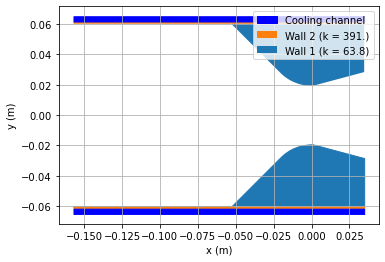

C:\Users\Daniel\anaconda3\lib\site-packages\cusfbamboo\hx.py:84: UserWarning: ReDh < 3500 in cooling channels: Flow is in between the laminar and turbulent regions - blending will be used. Constant wall temperature is assumed for laminar Nusselt number.
  R = self.Rdx(self.state[i]))
<ipython-input-6-f3c27688b681>:32: UserWarning: More than one wall is present. Thermal stresses calculations will ignore any incompatibility in different thermal expansions.
  cooling_data = engine.steady_heating_analysis(iter_start = 15, iter_each = 3)
C:\Users\Daniel\anaconda3\lib\site-packages\cusfbamboo\engine.py:1251: RuntimeWarning: divide by zero encountered in double_scalars
  results["sigma_t_pressure"][i][j] = (p_l - p_g) * D / (2 * t_w)


In [6]:
# Set up the objects we need
perfect_gas = bam.PerfectGas(gamma = gamma, cp = cp)                   # Approximate values for CO2
chamber_conditions = bam.ChamberConditions(p0 = pc, T0 = Tc)
geometry = bam.Geometry(xs = xs, rs = rs)

copper_wall = bam.Wall(material = copper_material, thickness = inner_wall_thickness) 
graphite_wall = bam.Wall(material = graphite_material, thickness = graphite_thickness) 

# Main inputs
engine = bam.Engine(perfect_gas = perfect_gas, 
                    chamber_conditions = chamber_conditions, 
                    geometry = geometry,
                    exhaust_transport = exhaust_transport,
                    walls = [graphite_wall, copper_wall])

# Add a cooling jacket to the engine
engine.cooling_jacket = bam.CoolingJacket(T_coolant_in = inlet_T, 
                                         p_coolant_in = inlet_p, 
                                         mdot_coolant = mdot_coolant, 
                                         channel_height = channel_height,
                                         blockage_ratio = blockage_ratio,
                                         number_of_channels = number_of_fins,
                                         coolant_transport = coolant_transport,
                                         configuration = 'vertical',
                                         restrain_fins = False)

engine.plot()
plt.savefig("img/engine.svg")
plt.savefig("img/engine.pdf")
bam.show()

cooling_data = engine.steady_heating_analysis(iter_start = 15, iter_each = 3)

### Plot simulation results

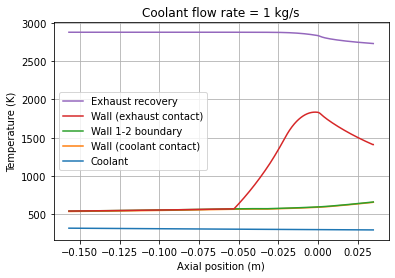

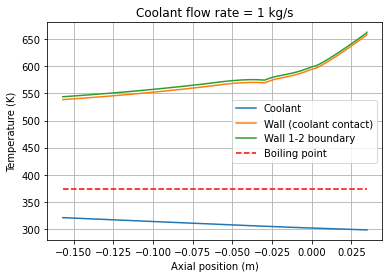

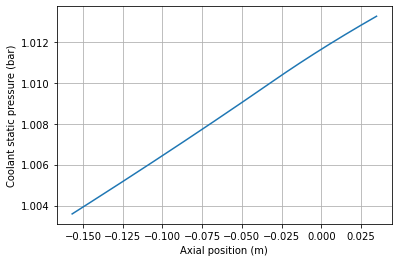

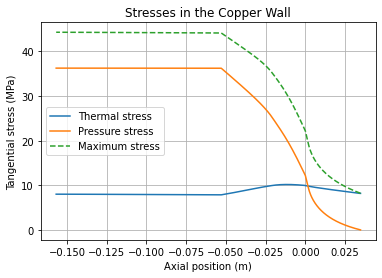

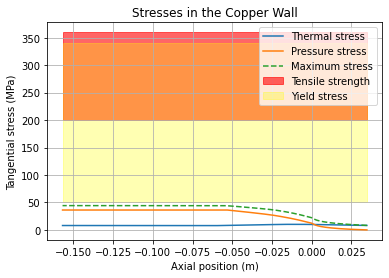

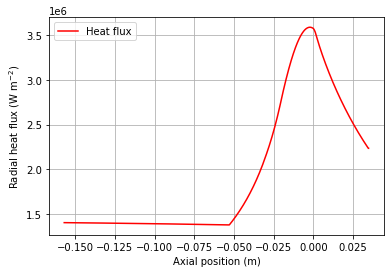

In [7]:
# Plot temperatures
bam.plot.plot_temperatures(cooling_data)
plt.title(f"Coolant flow rate = {mdot_coolant} kg/s")
bam.show()

bam.plot.plot_temperatures(cooling_data, only_indexes = [0,1,2])
plt.title(f"Coolant flow rate = {mdot_coolant} kg/s")

plt.hlines(y = PropsSI("T", "Q", 0, "P", 1e5, "WATER"), 
           label ="Boiling point", 
           color = "red", 
           linestyle = "--", 
           xmin =xs[0], 
           xmax = xs[-1])


plt.legend()
plt.savefig("img/temperatures.svg")
plt.savefig("img/temperatures.pdf")
bam.show()

# Plot coolant pressures
bam.plot.plot_p_coolant(cooling_data)
plt.savefig("img/p_coolant.svg")
plt.savefig("img/p_coolant.pdf")
bam.show()

# Plot stresses
bam.plot.plot_tangential_stress(cooling_data, wall_index = 1)
plt.title("Stresses in the Copper Wall")
plt.legend()
plt.savefig("img/stresses.svg")
plt.savefig("img/stresses.pdf")
bam.show()

# Failure data for C106 in MPa - https://www.azom.com/article.aspx?ArticleID=2851
yield_min = 50
yield_max = 340
yield_height = yield_max - yield_min

tensile_strength_min = 200
tensile_strength_max = 360
tensile_strength_height = tensile_strength_max - tensile_strength_min

xy_yield = (cooling_data["x"][-1], yield_min)
xy_tensile_strength = (cooling_data["x"][-1], tensile_strength_min)
width = cooling_data["x"][0] - cooling_data["x"][-1]

bam.plot.plot_tangential_stress(cooling_data, wall_index = 1)
plt.title("Stresses in the Copper Wall")

sigma_ts = patches.Rectangle(xy_tensile_strength, 
                             width, 
                             tensile_strength_height, 
                             label = "Tensile strength", 
                             alpha = 0.6, 
                             color = "red")

sigma_y = patches.Rectangle(xy_yield, 
                            width, 
                            yield_height, 
                            label = "Yield stress", 
                            alpha = 0.3, 
                            color = "yellow")

plt.gca().add_patch(sigma_ts)
plt.gca().add_patch(sigma_y)

plt.legend()
plt.savefig("img/stresses_with_limits.svg")
plt.savefig("img/stresses_with_limits.pdf")
bam.show()


# Plot heat fluxes
bam.plot.plot_q_per_area(cooling_data)
bam.show()

### Useful engine data

In [8]:
print(f"""
OPERATING CONDITIONS
--------------------
Mass flow rate = {mdot_froz:.3f} kg/s

Sea level thrust     = {engine.thrust(1e5)/1000:.3f} kN      (perfect gas relations)
Sea level thrust     = {isp_froz * mdot_froz/1000:.3f} kN      (frozen flow - PyProPEP)
Sea level thrust     = {isp_shift * mdot_shift/1000:.3f} kN      (equilibrium flow - PyProPEP)

Sea level Isp        = {engine.isp(1e5)/9.80665:.3f} s     (perfect gas relations)
Sea level Isp        = {isp_froz/9.80665:.3f} s     (frozen flow - PyProPEP)
Sea level Isp        = {isp_shift/9.80665:.3f} s     (equilibrium flow - PyProPEP)

Chamber Temperature  = {Tc:.3f} K
Gamma                = {gamma:.3f}
cp                   = {cp:.3f} J/kg/K
""")

print(f"""
GEOMETRY
--------
Chamber length       = {1e3*Lc:.4f} mm (injector face to start of converging section)   
Nozzle length        = {1e3*(xs[-1] - xs[0] - Lc):.4f} mm  (start of converging section to exit)
Total engine length  = {1e3*(xs[-1] - xs[0]):.4f} mm (injector face to nozzle exit)

Throat area          = {geometry.A_t:.5f} m^2  (Bamboo - perfect gas)
Throat area          = {At_froz:.5f} m^2  (PyProPEP - frozen flow)
Throat area          = {At_shift:.5f} m^2  (PyProPEP - equilibrium flow)

Throat radius        = {1e3*(geometry.A_t/np.pi)**0.5:.1f} mm  (Bamboo - perfect gas)
Throat radius        = {1e3*(At_froz/np.pi)**0.5:.1f} mm  (PyProPEP - frozen flow)
Throat radius        = {1e3*(At_shift/np.pi)**0.5:.1f} mm  (PyProPEP - equilibrium flow)

Exit area            = {geometry.A_e:.5f} m^2  (Bamboo - perfect gas)
Exit area            = {At_froz * area_ratio_froz:.5f} m^2  (PyProPEP - frozen flow)
Exit area            = {At_shift * area_ratio_shift:.5f} m^2  (PyProPEP - frozen flow)

Exit radius          = {1e3*(geometry.A_e/np.pi)**0.5:.1f} mm  (Bamboo - perfect gas)
Exit radius          = {1e3*(Ae_froz/np.pi)**0.5:.1f} mm  (PyProPEP - frozen flow)
Exit radius          = {1e3*(Ae_shift/np.pi)**0.5:.1f} mm  (PyProPEP - equilibrium flow)
""")


OPERATING CONDITIONS
--------------------
Mass flow rate = 0.790 kg/s

Sea level thrust     = 1.485 kN      (perfect gas relations)
Sea level thrust     = 1.500 kN      (frozen flow - PyProPEP)
Sea level thrust     = 1.500 kN      (equilibrium flow - PyProPEP)

Sea level Isp        = 194.261 s     (perfect gas relations)
Sea level Isp        = 193.734 s     (frozen flow - PyProPEP)
Sea level Isp        = 197.292 s     (equilibrium flow - PyProPEP)

Chamber Temperature  = 2875.985 K
Gamma                = 1.236
cp                   = 1775.153 J/kg/K


GEOMETRY
--------
Chamber length       = 104.0990 mm (injector face to start of converging section)   
Nozzle length        = 87.6562 mm  (start of converging section to exit)
Total engine length  = 191.7551 mm (injector face to nozzle exit)

Throat area          = 0.00117 m^2  (Bamboo - perfect gas)
Throat area          = 0.00117 m^2  (PyProPEP - frozen flow)
Throat area          = 0.00117 m^2  (PyProPEP - equilibrium flow)

Throat radiu